# Data Processing

In [149]:
#Load Documents 
import glob
import numpy as np
import spacy
import string
from collections import Counter
from progressbar import ProgressBar
from nltk.corpus import stopwords
import time
from tqdm import tqdm
import dill
import numpy as np
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F


#Create File Index for Train and Val Data
def create_index(path,num_val_samples):
    pos = glob.glob(path+ "pos/*")
    neg = glob.glob(path+ "neg/*")
    pos = np.column_stack((pos,(np.ones(len(pos),dtype=int))))  # Label 1
    neg = np.column_stack((neg,(np.zeros(len(neg),dtype=int))))  # Label 0
    data= np.vstack((pos,neg))
    
    #Create Files Names For Val and Train Set
    np.random.shuffle(data)
    val, test = data[:num_val_samples,:], data[num_val_samples:,:]
    
    #Save files
    np.savetxt("val_path.txt",val[:,0], delimiter=",", fmt="%s") 
    np.savetxt("val_target.txt",val[:,1], delimiter=",", fmt= "%s")
    np.savetxt("test_path.txt",test[:,0], delimiter=",", fmt = "%s") 
    np.savetxt("test_target.txt",test[:,1], delimiter=",", fmt= "%s") 


def read_data(files):
    lines= []
    for f in files:
        with open(f) as file:
            for line in file: 
                line = line.strip().lower().split()
                lines.append(line) #storing everything in memory!
                
    return np.array(lines)
        

def load_data(path):
    if isinstance(path, list):
        data = read_data(path)
        
    else:
        pos = read_data(glob.glob(path+ "pos/*"))
        neg = read_data(glob.glob(path+ "neg/*"))
            
        #Create Labels for Pos and Negative Reviews
        pos = np.column_stack((pos,(np.ones(len(pos),dtype=int))))  # Label 1
        neg = np.column_stack((neg,(np.zeros(len(neg),dtype=int))))  # Label 0
        data= np.vstack((pos,neg))
        np.random.shuffle(data)
    return data
    
    
#Training Data
train_data = load_data("/Users/Taurean/Documents/NLP-HW1/data/train/")
x_train, y_train = train_data[:,0], train_data[:,1]

#np.savetxt("train_target.txt",y_train, delimiter=",", fmt= "%s")

#Validation Data
x_val = load_data(list(np.genfromtxt("/Users/Taurean/Documents/NLP-HW1/val_path.txt",dtype='str')))
y_val = np.genfromtxt("/Users/Taurean/Documents/NLP-HW1/target/val_target.txt",dtype='int')

#Test Data
x_test = load_data(list(np.genfromtxt("/Users/Taurean/Documents/NLP-HW1/test_path.txt",dtype='str')))
y_test = np.genfromtxt("/Users/Taurean/Documents/NLP-HW1/target/test_target.txt",dtype='int')



In [343]:
def load_dill_file(path):
    with open(path, "rb") as dill_file:
        return dill.load(dill_file)


#Load Review Tokens 
x_train= load_dill_file("/Users/Taurean/Documents/NLP-HW1/tokens/train_tokens_clean")
x_val =  load_dill_file("/Users/Taurean/Documents/NLP-HW1/tokens/val_tokens_clean")
x_test = load_dill_file("/Users/Taurean/Documents/NLP-HW1/tokens/test_tokens_clean")


#Load Target Values
y_train = np.genfromtxt("/Users/Taurean/Documents/NLP-HW1/target/train_target.txt",dtype='int')
y_val = np.genfromtxt("/Users/Taurean/Documents/NLP-HW1/target/val_target.txt",dtype='int')
y_test = np.genfromtxt("/Users/Taurean/Documents/NLP-HW1/target/test_target.txt",dtype='int')



In [127]:
#Print Total Samples in the data
print("The number of samples in x_train is {:,d}".format(len(x_train)))
print("The number of samples in x_val is {:,d}".format(len(x_val)))
print("The number of samples in x_test is {:,d}".format(len(x_test)))

The number of samples in x_train is 25,000
The number of samples in x_val is 5,000
The number of samples in x_test is 20,000


# Hyperparameter Tuning

In [91]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 74.48
Test Acc 73.8


In [183]:
#Create N-grams
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))


#Maps Word to Id Number
def data_dictionary(reviews,vocab_size_limit):
    token_counter = Counter()
    PAD_IDX = 0
    UNK_IDX = 1
    for review in reviews:
        for words in set(review):
            token_counter[words] += 1
            

    vocab, count = zip(*token_counter.most_common(vocab_size_limit))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token
            
            
#Convert Review tokens to Id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else 0 for token in tokens]
        indices_data.append(index_list)
    return indices_data


#Parameters
n=1  # mac number of ngram_size
vocab_size_limit = 200
emb_dim = 100
learning_rate = 0.01
num_epochs = 1 # number epoch to train

x_test_tokens=[find_ngrams(x_test[i],n) for i in range(len(x_test))]
x_val_tokens=[find_ngrams(x_val[i],n) for i in range(len(x_val))]
x_train_tokens=[find_ngrams(x_train[i],n) for i in range(len(x_train))]
all_tokens= np.concatenate((x_test_tokens,x_val_tokens,x_train_tokens), axis=None)
    
    
print("Creating Word Dictionary")
x= data_dictionary(all_tokens,vocab_size_limit)
token2id= x[0]
id2token = x[1]

print("Tranforming word to Id")
train_data_indices = token2index_dataset(x_train_tokens)
val_data_indices = token2index_dataset(x_val_tokens)
test_data_indices = token2index_dataset(x_test_tokens)



MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of IMDB movie review tokens 
        @param target_list: list of IMDB movie review targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def IMBD_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = IMDBDataset(train_data_indices, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMBD_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=IMBD_collate_func,
                                         shuffle=True)

test_dataset = IMDBDataset(test_data_indices, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE,
                                          collate_fn=IMBD_collate_func,
                                          shuffle=False)
    
#import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F



class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 700 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('ngram: {}, Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc {}'.format(n, 
                 epoch+1, num_epochs, i+1, len(train_loader), val_acc,train_acc))
            n_gram.append(j)
            epoch_n.append(epoch+1)
            val_score.append(val_acc)
            test_score.append(train_acc)

Creating Word Dictionary
Tranforming word to Id
ngram: 1, Epoch: [1/1], Step: [701/782], Validation Acc: 74.16, Train Acc 73.936


In [352]:
#Parameters
n=4  # max number of ngram_size

n_gram=[]
n_epoch = []
val_score= []
train_score = []
for j in range(1,n+1):
    
    vocab_size_limit = 500
    emb_dim = 100
    learning_rate = 0.01
    num_epochs = 10 # number epoch to train

    x_test_tokens=[find_ngrams(x_test[i],j) for i in range(len(x_test))]
    x_val_tokens=[find_ngrams(x_val[i],j) for i in range(len(x_val))]
    x_train_tokens=[find_ngrams(x_train[i],j) for i in range(len(x_train))]
    all_tokens= np.concatenate((x_test_tokens,x_val_tokens,x_train_tokens), axis=None)
    
    
    print("Creating Word Dictionary")
    x= data_dictionary(all_tokens,vocab_size_limit)
    token2id= x[0]
    id2token = x[1]

    print("Tranforming word to Id")
    train_data_indices = token2index_dataset(x_train_tokens)
    val_data_indices = token2index_dataset(x_val_tokens)
    test_data_indices = token2index_dataset(x_test_tokens)

    print("Running Bag of Words Model")
    MAX_SENTENCE_LENGTH = 200


    BATCH_SIZE = 32
    train_dataset = IMDBDataset(train_data_indices, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=IMBD_collate_func,
                                           shuffle=True)

    val_dataset = IMDBDataset(val_data_indices, y_val)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=BATCH_SIZE,
                                         collate_fn=IMBD_collate_func,
                                         shuffle=True)

    test_dataset = IMDBDataset(test_data_indices, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE,
                                          collate_fn=IMBD_collate_func,
                                          shuffle=False)



    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer =torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    #scheduler =torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    for epoch in range(num_epochs):
        #scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 700 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                print('ngram: {}, Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc {}'.format(j, 
                epoch+1, num_epochs, i+1, len(train_loader), val_acc,train_acc))
                
                #Log Results
                n_gram.append(j)
                n_epoch.append(epoch)
                val_score.append(val_acc)
                train_score.append(train_acc)

Creating Word Dictionary
Tranforming word to Id
Running Bag of Words Model
ngram: 1, Epoch: [1/10], Step: [701/782], Validation Acc: 48.12, Train Acc 51.344
ngram: 1, Epoch: [2/10], Step: [701/782], Validation Acc: 52.4, Train Acc 51.056
ngram: 1, Epoch: [3/10], Step: [701/782], Validation Acc: 52.74, Train Acc 52.088
ngram: 1, Epoch: [4/10], Step: [701/782], Validation Acc: 51.26, Train Acc 51.464
ngram: 1, Epoch: [5/10], Step: [701/782], Validation Acc: 46.4, Train Acc 52.06
ngram: 1, Epoch: [6/10], Step: [701/782], Validation Acc: 51.52, Train Acc 52.916
ngram: 1, Epoch: [7/10], Step: [701/782], Validation Acc: 49.46, Train Acc 52.484
ngram: 1, Epoch: [8/10], Step: [701/782], Validation Acc: 49.7, Train Acc 53.488
ngram: 1, Epoch: [9/10], Step: [701/782], Validation Acc: 49.8, Train Acc 53.032
ngram: 1, Epoch: [10/10], Step: [701/782], Validation Acc: 51.44, Train Acc 52.792
Creating Word Dictionary
Tranforming word to Id
Running Bag of Words Model
ngram: 2, Epoch: [1/10], Step: [70

/anaconda3/envs/nlpclass/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


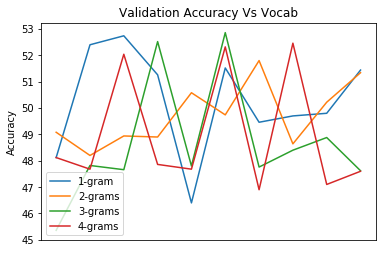

In [353]:
import pandas as pd
q=np.stack((n_gram,n_epoch,val_score,train_score), axis=-1)
q=pd.DataFrame(q,columns=['n_gram', 'n_epoch','val_score', 'train_score'])
q.set_index('n_epoch', inplace=True)
q.groupby('n_gram')['val_score'].plot(legend=True)
ax1 = plt.axes()
plt.title('Validation Accuracy Vs Vocab')
plt.legend(["1-gram","2-grams", "3-grams", "4-grams"])
plt.ylabel('Accuracy')
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.savefig('Vocab Valid Vocab(Stop Words).pdf')


/anaconda3/envs/nlpclass/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


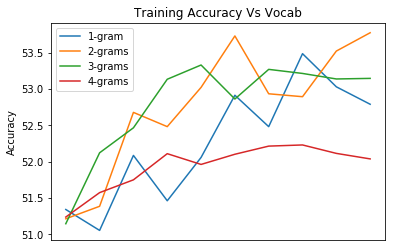

In [354]:
import pandas as pd
q=np.stack((n_gram,n_epoch,val_score,train_score), axis=-1)
q=pd.DataFrame(q,columns=['n_gram', 'n_epoch','val_score', 'train_score'])
q.set_index('n_epoch', inplace=True)
q.groupby('n_gram')['train_score'].plot(legend=True)
ax1 = plt.axes()
plt.title('Training Accuracy Vs Vocab')
plt.legend(["1-gram","2-grams", "3-grams", "4-grams"])
plt.ylabel('Accuracy')
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.savefig('Vocab Training Adj learning Adam 1.pdf')